In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
import os
from utils.utils import EDAHelperFunctions
from utils.cols_to_avoid import cols_to_avoid
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
helpers = EDAHelperFunctions()

In [4]:
country_name = 'croatia'
lhc_sampled_data_path = 'lhs_sampled_data'
features_csv_path = os.path.join(lhc_sampled_data_path, f'lhs_sampled_{country_name}_features.csv')
targets_csv_path = os.path.join(lhc_sampled_data_path, f'lhs_sampled_{country_name}_targets.csv')

## Let's start by cleaning the features data.

In [5]:
df_features = pd.read_csv(features_csv_path)
print('Features df initial shape: ', df_features.shape)
df_features.head()

Features df initial shape:  (434, 2220)


,id,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,1,croatia,0,8807000,56.277668,1697.578019,61.969326,4580.006502,616.746470,741.505688,...,4.123904e-06,0.0,25.591757,0.000061,0.163782,0.568801,0.427438,0.0,1.654619,0.0
1,2,croatia,0,8807000,77.275009,4238.243967,39.598957,9558.112595,251.360883,231.930587,...,9.211276e-09,0.0,24.497842,0.000026,0.120136,0.812281,0.760828,0.0,2.021306,0.0
2,3,croatia,0,8807000,45.393995,2110.698659,1.109575,10678.064456,203.149131,689.015013,...,5.385562e-06,0.0,29.598038,0.000007,0.117050,0.894419,0.518975,0.0,1.677986,0.0
3,4,croatia,0,8807000,82.356212,2469.058417,21.588101,692.350342,169.982023,539.884542,...,1.998330e-07,0.0,2.301042,0.000005,0.101745,0.130575,1.973134,0.0,1.010197,0.0
4,5,croatia,0,8807000,31.015584,497.211673,10.227688,5380.888870,80.485788,923.109247,...,2.814637e-08,0.0,11.278697,0.000098,0.153839,1.414877,0.754573,0.0,2.077984,0.0


In [6]:
df_features.drop(columns=['id', 'region', 'time_period'], inplace=True)
df_features.head()

,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,avgmass_lvst_animal_goats_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,8807000,56.277668,1697.578019,61.969326,4580.006502,616.746470,741.505688,226.619164,0.590571,34.824811,...,4.123904e-06,0.0,25.591757,0.000061,0.163782,0.568801,0.427438,0.0,1.654619,0.0
1,8807000,77.275009,4238.243967,39.598957,9558.112595,251.360883,231.930587,142.960658,1.836165,47.087903,...,9.211276e-09,0.0,24.497842,0.000026,0.120136,0.812281,0.760828,0.0,2.021306,0.0
2,8807000,45.393995,2110.698659,1.109575,10678.064456,203.149131,689.015013,520.875129,1.977200,22.713331,...,5.385562e-06,0.0,29.598038,0.000007,0.117050,0.894419,0.518975,0.0,1.677986,0.0
3,8807000,82.356212,2469.058417,21.588101,692.350342,169.982023,539.884542,132.103102,0.896196,12.802291,...,1.998330e-07,0.0,2.301042,0.000005,0.101745,0.130575,1.973134,0.0,1.010197,0.0
4,8807000,31.015584,497.211673,10.227688,5380.888870,80.485788,923.109247,189.659942,0.118361,21.449036,...,2.814637e-08,0.0,11.278697,0.000098,0.153839,1.414877,0.754573,0.0,2.077984,0.0


In [7]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Columns: 2217 entries, area_gnrl_country_ha to nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
dtypes: float64(2092), int64(125)
memory usage: 7.3 MB


### Check NaNs

In [8]:
# Check for cols with null values
null_columns = helpers.check_null_values(df_features)

No null values found


In [9]:
# Double checking
df_features[null_columns].head()

""
0
1
2
3
4


In [10]:
# For now we drop if there is any NaN. It seems our attributes do not have NaNs so this is just for safety
df_features.dropna(axis=0, inplace=True)
print('Attributes df shape after using dropna: ', df_features.shape)

Attributes df shape after using dropna:  (434, 2217)


In [11]:
# Double check
helpers.check_null_values(df_features)

No null values found


[]

### Check cols that have the same value repeated

- If they are all 0 they can be dropped.
- If they have the same number they will not contribute to the variation we need.

TODO: Check the cols with the same number because they same to be important even though they have the repeated value. 

In [12]:
# Check for columns that have the same value in all rows
cols_with_repeated_zeros, cols_with_repeated_non_zeros = helpers.check_cols_with_same_val(df_features)

Amount of cols with repeated value zero:  267
Amount of cols with repeated value not zero:  144


In [13]:
[col for col in cols_with_repeated_non_zeros if col not in cols_to_avoid]

[]

In [14]:
cols_with_repeated_zeros

['consumpinit_inen_energy_tj_per_tonne_production_wood',
 'consumpinit_scoe_tj_per_mmmgdp_other_se_elec_appliances',
 'consumpinit_scoe_tj_per_mmmgdp_other_se_heat_energy',
 'ef_fgtv_production_fugitive_tonne_ch4_per_m3_fuel_coal',
 'ef_fgtv_production_fugitive_tonne_co2_per_m3_fuel_coal',
 'ef_fgtv_production_venting_tonne_n2o_per_m3_fuel_oil',
 'ef_fgtv_transmission_tonne_n2o_per_m3_fuel_oil',
 'ef_ippu_tonne_c2f6_per_mmm_gdp_product_use_ods_other',
 'ef_ippu_tonne_c2f6_per_tonne_production_chemicals',
 'ef_ippu_tonne_c2f6_per_tonne_production_electronics',
 'ef_ippu_tonne_c2f6_per_tonne_production_metals',
 'ef_ippu_tonne_c2h3f3_per_tonne_production_chemicals',
 'ef_ippu_tonne_c2hf5_per_tonne_production_chemicals',
 'ef_ippu_tonne_c3f8_per_tonne_production_chemicals',
 'ef_ippu_tonne_c3f8_per_tonne_production_electronics',
 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_other',
 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_refrigeration',
 'ef_ippu_tonne_c3h3f5_per_mmm_gdp_p

In [15]:
df_features[cols_with_repeated_non_zeros]

,area_gnrl_country_ha,frac_agrc_agriculture_production_lost,frac_agrc_production_lost_sent_to_msw,frac_enfu_transmission_loss_fuel_electricity,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biogas,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biomass,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal_ccs,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas,frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas_ccs,...,pij_lndu_wetlands_to_forests_secondary,pij_lndu_wetlands_to_grasslands,pij_lndu_wetlands_to_other,pij_lndu_wetlands_to_settlements,pij_lndu_wetlands_to_wetlands,population_gnrl_rural,population_gnrl_urban,frac_soil_gasm_n_volatilisation_organic_amendments_fertilizer,frac_soil_leachh_n_lost_to_leaching,nemomod_entc_grid_power_constraint_mmm_usd
0,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
1,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
2,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
3,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
4,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
430,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
431,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999
432,8807000,0.21024,0.3,0.149662,-999,-999,-999,-999,-999,-999,...,0.000791,0.008368,0.000125,0.000319,0.97894,1.791084e+06,2.293953e+06,0.21,0.360385,-999


In [16]:
# df_features.drop(columns=cols_with_repeated_values, inplace=True)
# print('Attributes df shape after dropping cols with all same values: ', df_attributes.shape)

In [17]:
# Double Check elimination
# cols_with_repeated_values = helpers.check_cols_with_same_val(df_attributes)

## Now let's move to analyze the target variables

In [18]:
df_target_vars = pd.read_csv(targets_csv_path)
df_target_vars.head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
0,30.551210,0.0,824.705055,43.298938,0.982874,2.000877,13.640680,0.815422,1.135699,0.901483,3.433181,9.137922,328.261203,0.298723,0.721401
1,18.066474,0.0,33.773666,5.218461,1.973289,4.000400,13.966889,0.962788,2.624060,2.851881,1.331855,5.201396,106.538608,1.360968,1.001783
2,74.847351,0.0,156.935479,14.573273,-1.311673,8.610497,16.293341,0.376301,0.894248,0.770580,7.678961,4.866509,64.270375,0.042896,0.867661
3,47.955499,0.0,14.399265,1.876271,-0.571858,2.819088,2.207974,0.484330,0.759836,1.269707,7.569203,8.817784,18.475614,0.679835,1.190569
4,23.010139,0.0,16.955549,1.431149,3.973356,6.509137,11.661773,0.514767,0.604407,3.121795,7.053433,6.211879,25.705139,0.585810,0.851897


In [19]:
# Checkinng null values
helpers.check_null_values(df_target_vars)

No null values found


[]

In [20]:
helpers.check_cols_with_same_val(df_target_vars)

Amount of cols with repeated value zero:  1
Amount of cols with repeated value not zero:  0


(['emission_co2e_subsector_total_ccsq'], [])

## Addressing outliers
Using IQR to cap the outliers

In [21]:
df_target_vars.columns

Index(['emission_co2e_subsector_total_agrc',
       'emission_co2e_subsector_total_ccsq',
       'emission_co2e_subsector_total_entc',
       'emission_co2e_subsector_total_fgtv',
       'emission_co2e_subsector_total_frst',
       'emission_co2e_subsector_total_inen',
       'emission_co2e_subsector_total_ippu',
       'emission_co2e_subsector_total_lndu',
       'emission_co2e_subsector_total_lsmm',
       'emission_co2e_subsector_total_lvst',
       'emission_co2e_subsector_total_scoe',
       'emission_co2e_subsector_total_soil',
       'emission_co2e_subsector_total_trns',
       'emission_co2e_subsector_total_trww',
       'emission_co2e_subsector_total_waso'],
      dtype='object')

In [22]:
# Test target variable
test_target_var = 'emission_co2e_subsector_total_agrc'

In [23]:
df_features_capped = helpers.cap_outliers_iqr(df_features)

In [24]:
print('Shape before capping: ', df_features.shape)
print('Shape after capping: ', df_features_capped.shape)

Shape before capping:  (434, 2217)
Shape after capping:  (434, 2217)


In [25]:
# [col for col in df_features.columns if col.startswith('frac_agrc')]

<Axes: >

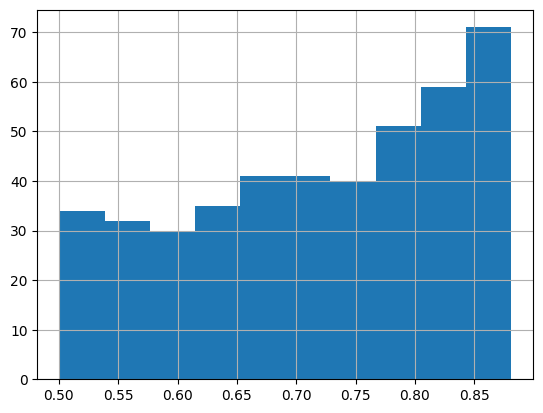

In [26]:
df_features['frac_agrc_bevs_and_spices_cl1_temperate'].hist()

<Axes: >

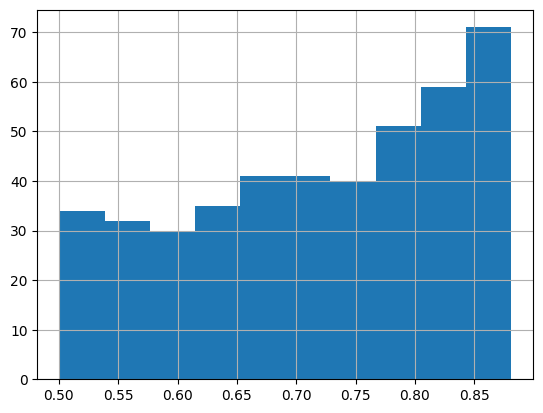

In [27]:
df_features_capped['frac_agrc_bevs_and_spices_cl1_temperate'].hist()

<Axes: >

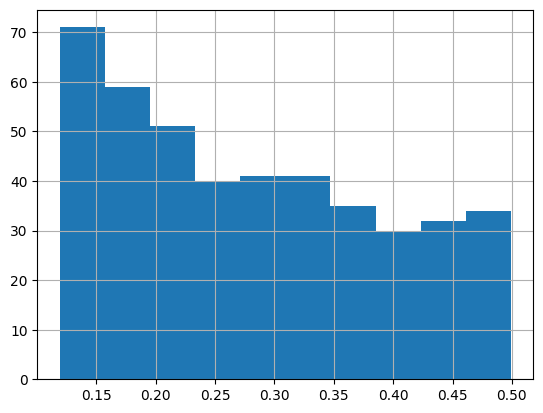

In [28]:
df_features_capped['frac_agrc_bevs_and_spices_cl1_tropical'].hist()

In [29]:
df_target_vars_capped = helpers.cap_outliers_iqr(df_target_vars)

In [30]:
print('Shape before capping: ', df_target_vars.shape)
print('Shape after capping: ', df_target_vars_capped.shape)

Shape before capping:  (434, 15)
Shape after capping:  (434, 15)


Test target var before capping


<Axes: >

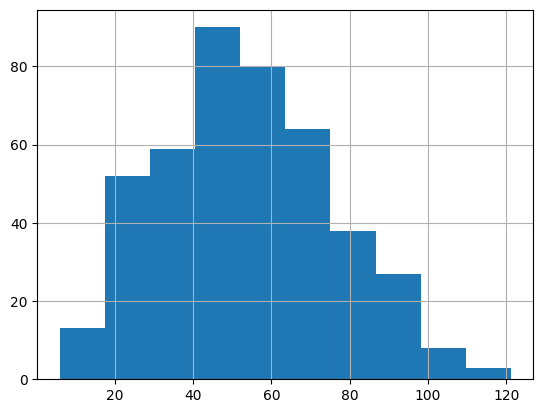

In [31]:
print('Test target var before capping')
df_target_vars[test_target_var].hist()

Test target var after capping


<Axes: >

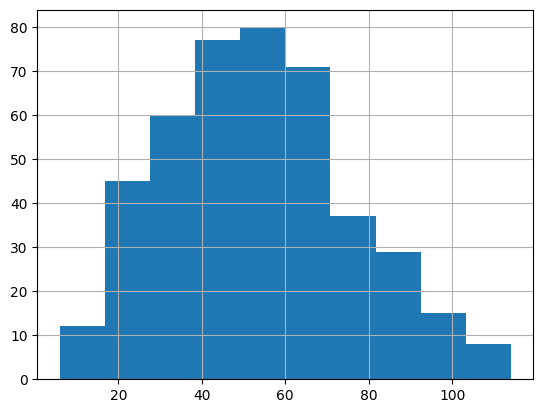

In [32]:
print('Test target var after capping')
df_target_vars_capped[test_target_var].hist()

## ML Part

### Feature importance with RF (Testing with FGTV and without dealing with outliers)

In [33]:
X = df_features_capped
y = df_target_vars_capped[test_target_var]

In [34]:
print(X.shape, y.shape)

(434, 2217) (434,)


 - Target variable stats:
   Var: 487.93285572264165, StDev: 22.089202242784634, IQR: 30.750762995219667


/home/tony-ubuntu/anaconda3/envs/calibration_env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/tony-ubuntu/anaconda3/envs/calibration_env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Evaluation Metrics:
 - Mean Squared Error: 665.9837022218613
 - R2 Score: -0.17695892596748908


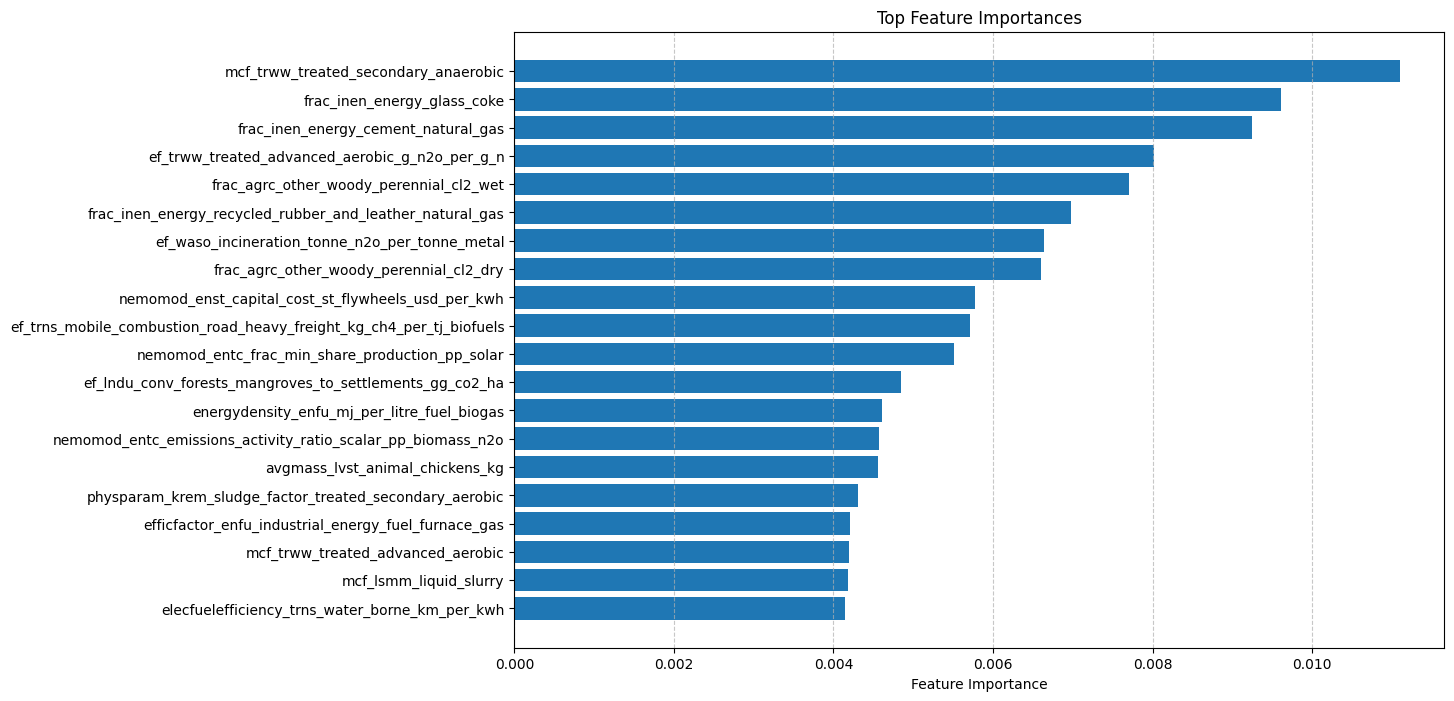

In [35]:
from utils.utils import TreeRegressionModels

feature_importance_rd = TreeRegressionModels(X, y, threshold=0.004)
results_dict = feature_importance_rd.run_feature_selector()

In [36]:
results_dict.keys()

dict_keys(['X_train_selected', 'X_test_selected', 'mse', 'r2', 'feature_importances'])

In [41]:
X_train_selected = results_dict['X_test_selected']
X_train_selected.shape

(87, 21)

In [40]:
feature_importance_rd.hyperparameter_tuning_rf(X_train_selected, y)

ValueError: Found input variables with inconsistent numbers of samples: [87, 434]

dict_keys(['X_train_selected', 'X_test_selected', 'mse', 'r2', 'feature_importances'])

In [60]:
important_features = results_dict['feature_importances']
important_features.head()

,Feature,Importance
0,mcf_trww_treated_secondary_anaerobic,0.011101
1,frac_inen_energy_glass_coke,0.009604
2,frac_inen_energy_cement_natural_gas,0.009241
3,ef_trww_treated_advanced_aerobic_g_n2o_per_g_n,0.008016
4,frac_agrc_other_woody_perennial_cl2_wet,0.007701


In [61]:
ten_most_important_ft = important_features.Feature[:10]

In [62]:
X_important = X[ten_most_important_ft]
important_df = pd.concat([X_important, y], axis=1)
important_df.head()

,mcf_trww_treated_secondary_anaerobic,frac_inen_energy_glass_coke,frac_inen_energy_cement_natural_gas,ef_trww_treated_advanced_aerobic_g_n2o_per_g_n,frac_agrc_other_woody_perennial_cl2_wet,frac_inen_energy_recycled_rubber_and_leather_natural_gas,ef_waso_incineration_tonne_n2o_per_tonne_metal,frac_agrc_other_woody_perennial_cl2_dry,nemomod_enst_capital_cost_st_flywheels_usd_per_kwh,ef_trns_mobile_combustion_road_heavy_freight_kg_ch4_per_tj_biofuels,emission_co2e_subsector_total_agrc
0,1.159819,0.071349,0.083439,0.007407,0.502766,0.089064,0.000073,0.497234,4556.556278,111.991812,30.551210
1,0.322533,0.071616,0.093515,0.015827,0.525368,0.112159,0.000020,0.474632,3465.348554,84.246995,18.066474
2,0.199975,0.071402,0.071083,0.017234,0.504900,0.083566,0.000030,0.495100,2068.423316,7.498210,74.847351
3,0.032673,0.071145,0.091840,0.001711,0.860720,0.115724,0.000083,0.139280,2660.388468,58.062971,47.955499
4,0.149293,0.069377,0.104380,0.020698,0.870033,0.137400,0.000113,0.129967,2643.206949,104.719138,23.010139


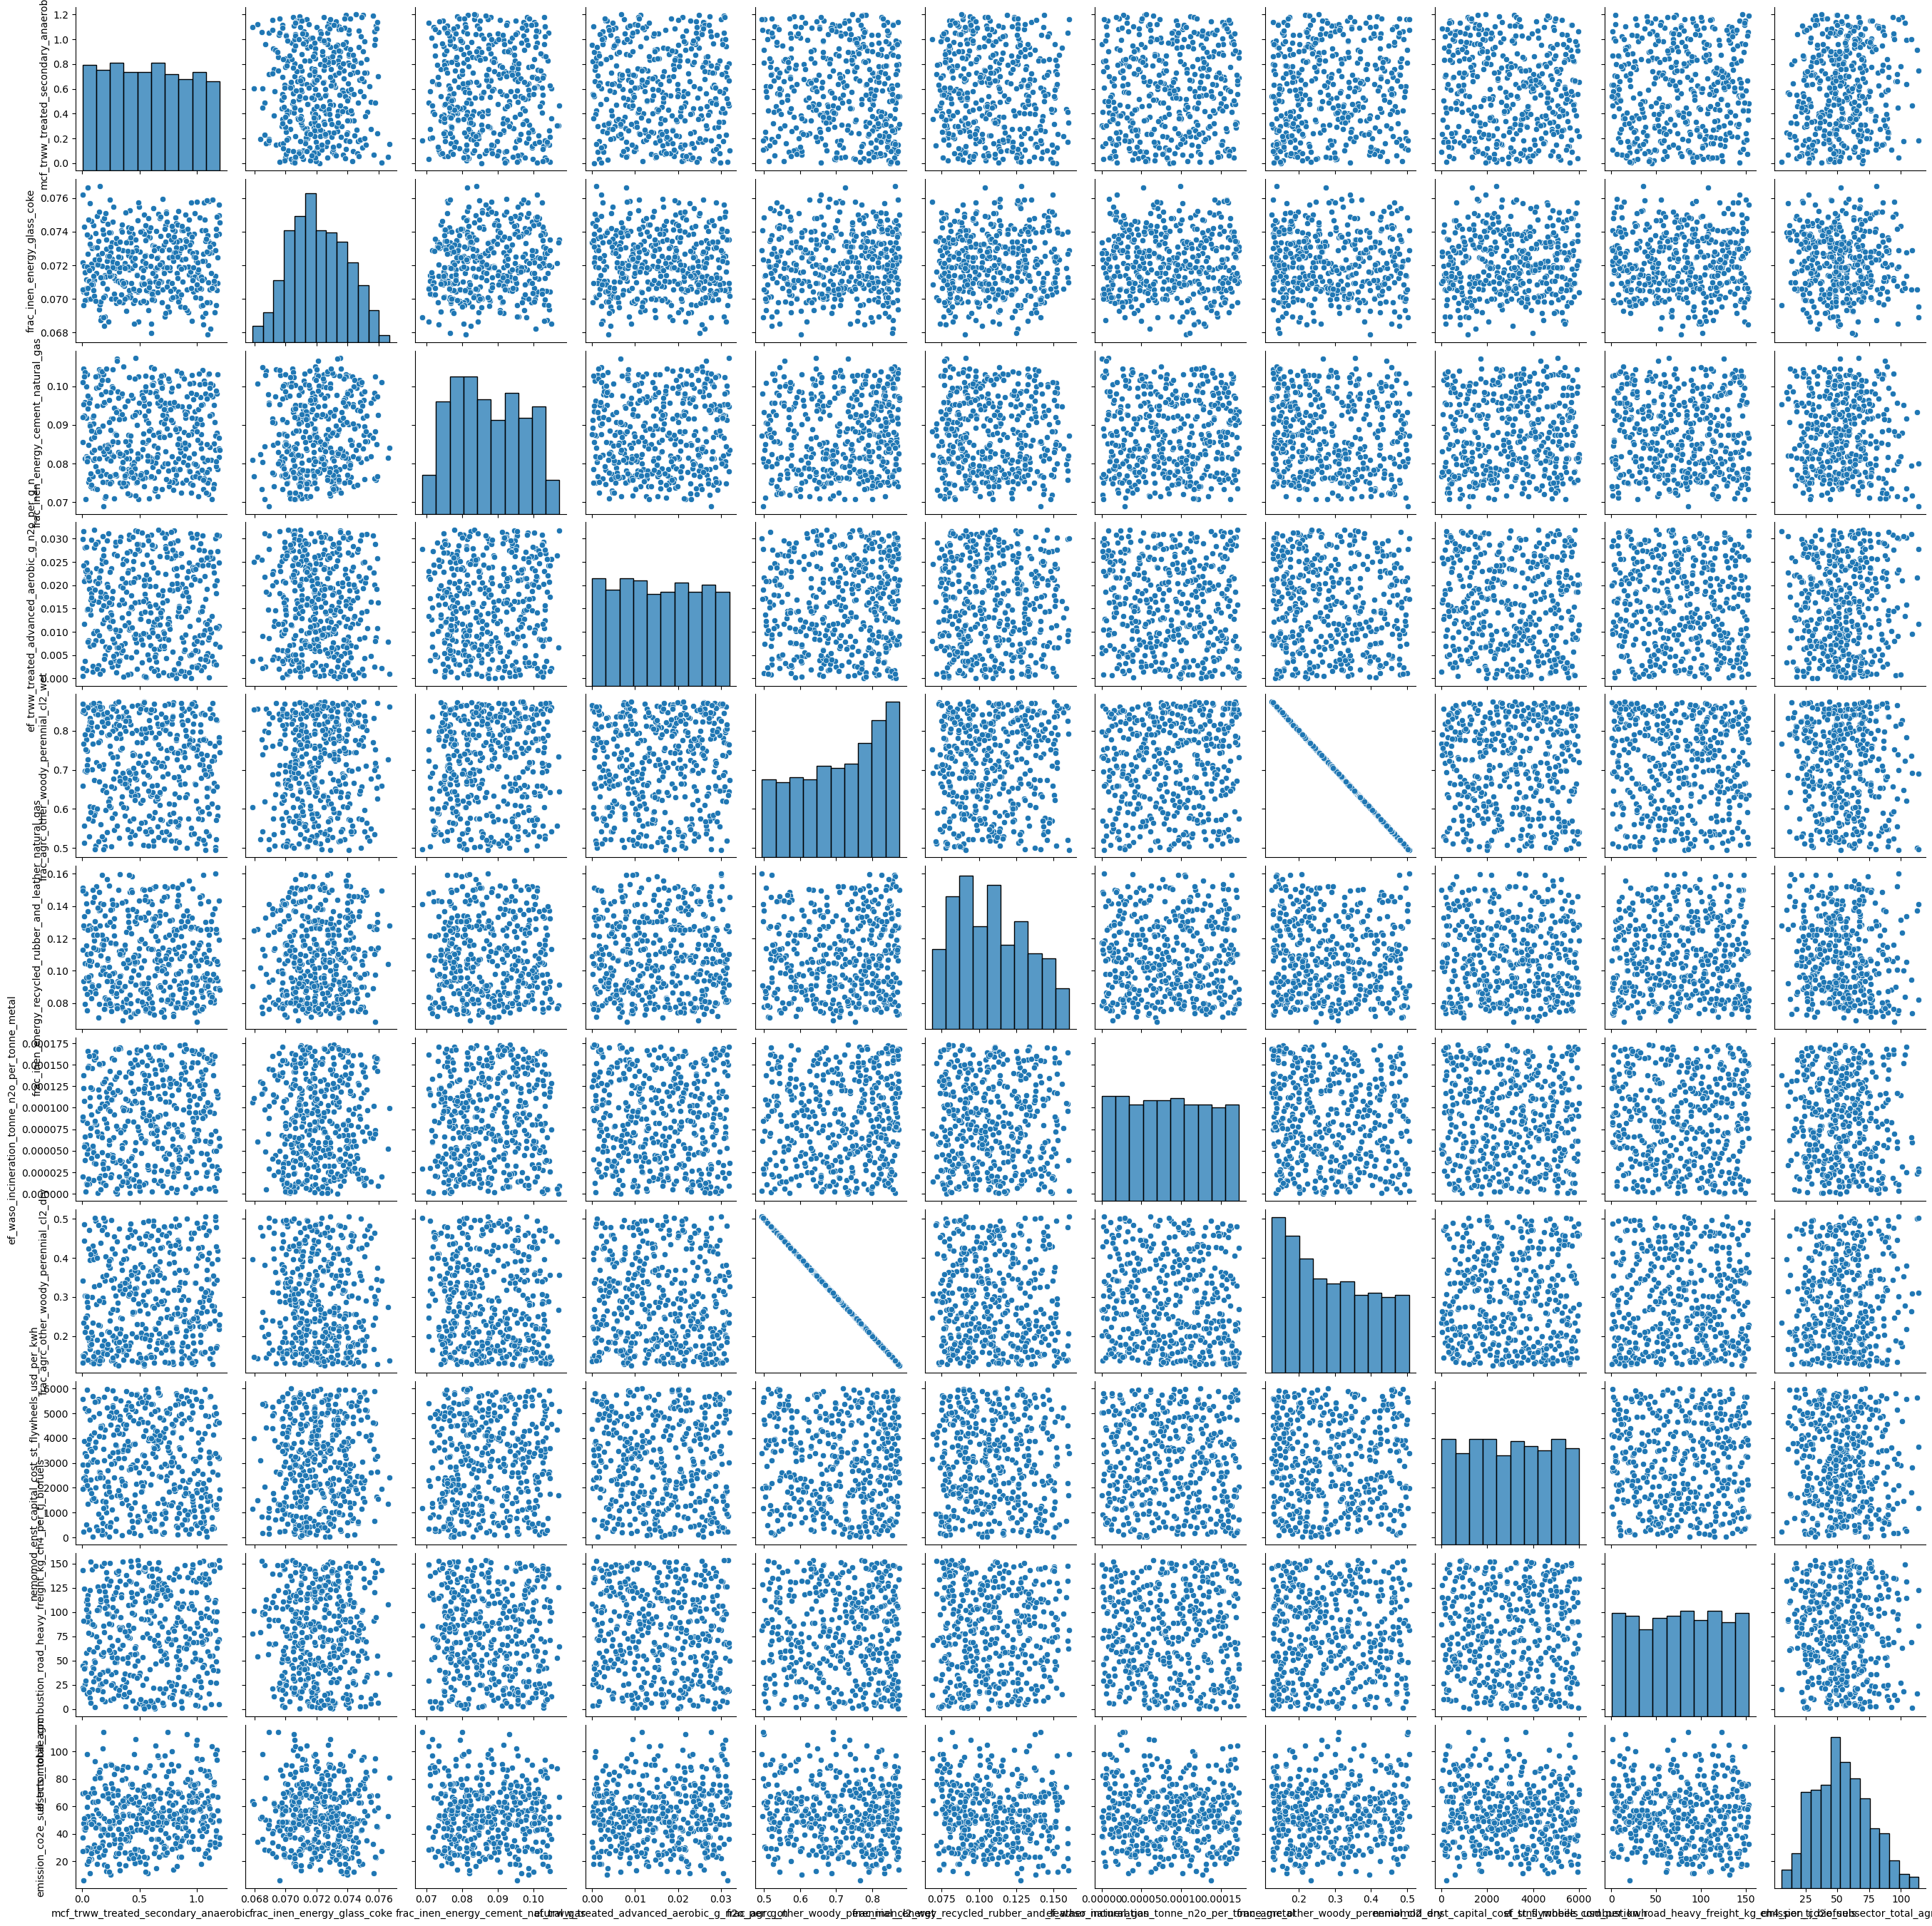

In [63]:
import seaborn as sns

sns.pairplot(important_df)


In [65]:
corr = important_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,mcf_trww_treated_secondary_anaerobic,frac_inen_energy_glass_coke,frac_inen_energy_cement_natural_gas,ef_trww_treated_advanced_aerobic_g_n2o_per_g_n,frac_agrc_other_woody_perennial_cl2_wet,frac_inen_energy_recycled_rubber_and_leather_natural_gas,ef_waso_incineration_tonne_n2o_per_tonne_metal,frac_agrc_other_woody_perennial_cl2_dry,nemomod_enst_capital_cost_st_flywheels_usd_per_kwh,ef_trns_mobile_combustion_road_heavy_freight_kg_ch4_per_tj_biofuels,emission_co2e_subsector_total_agrc
mcf_trww_treated_secondary_anaerobic,1.000000,0.035799,-0.020322,-0.026790,-0.084012,-0.082064,0.072464,0.084012,-0.059122,0.055931,0.153849
frac_inen_energy_glass_coke,0.035799,1.000000,0.076001,-0.047002,0.055378,0.053989,-0.010246,-0.055378,0.068823,0.001737,-0.059238
frac_inen_energy_cement_natural_gas,-0.020322,0.076001,1.000000,0.052976,0.083882,-0.017223,0.039155,-0.083882,0.057108,-0.056434,-0.047261
ef_trww_treated_advanced_aerobic_g_n2o_per_g_n,-0.026790,-0.047002,0.052976,1.000000,0.071974,0.007584,-0.044598,-0.071974,-0.060082,-0.080761,0.055437
frac_agrc_other_woody_perennial_cl2_wet,-0.084012,0.055378,0.083882,0.071974,1.000000,0.075212,0.087677,-1.000000,-0.012821,-0.018825,-0.093206
frac_inen_energy_recycled_rubber_and_leather_natural_gas,-0.082064,0.053989,-0.017223,0.007584,0.075212,1.000000,-0.008238,-0.075212,-0.005073,0.028606,-0.098356
ef_waso_incineration_tonne_n2o_per_tonne_metal,0.072464,-0.010246,0.039155,-0.044598,0.087677,-0.008238,1.000000,-0.087677,-0.037789,0.014253,-0.040257
frac_agrc_other_woody_perennial_cl2_dry,0.084012,-0.055378,-0.083882,-0.071974,-1.000000,-0.075212,-0.087677,1.000000,0.012821,0.018825,0.093206
nemomod_enst_capital_cost_st_flywheels_usd_per_kwh,-0.059122,0.068823,0.057108,-0.060082,-0.012821,-0.005073,-0.037789,0.012821,1.000000,-0.002599,-0.092005
ef_trns_mobile_combustion_road_heavy_freight_kg_ch4_per_tj_biofuels,0.055931,0.001737,-0.056434,-0.080761,-0.018825,0.028606,0.014253,0.018825,-0.002599,1.000000,-0.056238


In [84]:
important_df.var()

demscalar_ippu_plastic                                                                 3.344483e-01
nemomod_entc_output_activity_ratio_fuel_production_fp_petroleum_refinement_gasoline    7.686331e-02
nemomod_entc_capital_cost_pp_wind_mm_usd_per_gw                                        2.181903e+06
ratio_agrc_below_ground_to_above_ground_biomass_other_annual                           7.224046e-03
deminit_frst_wood_home_use_kg_per_hh                                                   9.297793e+04
ef_enfu_combustion_tonne_co2_per_tj_fuel_natural_gas                                   1.215736e+03
ef_waso_incineration_tonne_n2o_per_tonne_rubber_leather                                2.528041e-09
energydensity_gravimetric_enfu_gj_per_tonne_fuel_coal                                  1.950788e+02
efficfactor_enfu_industrial_energy_fuel_diesel                                         1.882453e-01
efficfactor_scoe_heat_energy_residential_hydrocarbon_gas_liquids                       1.886543e-01


#